# STEP1 Sampling Vedio frames


In [0]:
from google.colab import drive
from google.colab import files
import pathlib
import os

import pandas as pd
from subprocess import check_output
import numpy as np
import matplotlib.pyplot as plt

from skimage import io
from PIL import Image

drive.mount('/content/gdrive')
path = 'gdrive/My Drive/Colab Notebooks/VideoVisualization/'

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Saving sample.mp4 to sample.mp4
User uploaded file "sample.mp4" with length 3143463 bytes


In [0]:
import cv2

def video2frame(invideofilename, save_path):
    vidcap = cv2.VideoCapture(invideofilename)
    count = 0
    while True:
      success,image = vidcap.read()
      if not success:
          break
      #print ('Read a new frame: ', success)
      fname = "{}.jpg".format("{0:05d}".format(count))
      cv2.imwrite(save_path + fname, image) # save frame as JPEG file
      count += 1
    print("{} images are extracted in {}.". format(count, save_path))

In [0]:
path_sampling = 'gdrive/My Drive/Colab Notebooks/VideoVisualization/sampling/'
pathlib.Path(path_sampling).mkdir(parents=True, exist_ok=True)
video2frame("sample.mp4", path_sampling)

# STEP2 Weighted Color Palette 

In [0]:
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

class DominantColors:

    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    
    def __init__(self, image, clusters=3):
        self.CLUSTERS = clusters
        self.IMAGE = image
        
    def dominantColors(self):
        img = cv2.imread(self.IMAGE)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        self.IMAGE = img
        kmeans = KMeans(n_clusters = self.CLUSTERS)
        kmeans.fit(img)
        self.COLORS = kmeans.cluster_centers_
        self.LABELS = kmeans.labels_
        return self.COLORS.astype(int)
    def rgb_to_hex(self, rgb):
        return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))
    
    def plotClusters(self):
        fig = plt.figure()
        ax = Axes3D(fig)   
        ax.set_xlabel('RED')
        ax.set_ylabel('GREEN')
        ax.set_zlabel('BLUE')
        count = 0 

        for label, pix in zip(self.LABELS, self.IMAGE):
            count = count + 1
            if(count % int(pow(self.LABELS.size, 1/2)) == 0):
              ax.scatter(pix[0], pix[1], pix[2], color = self.rgb_to_hex(self.COLORS[label]))
        plt.title("Color Clustering")
        plt.show()

    def plotHistogram(self):
        numLabels = np.arange(0, self.CLUSTERS+1)   
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        colors = self.COLORS
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 

        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0

        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500

            r = colors[i][0]
            g = colors[i][1]
            b = colors[i][2]

            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end	

        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()

773


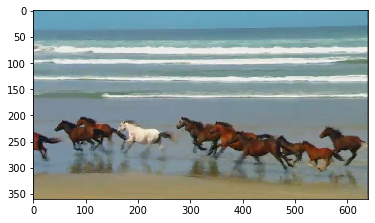

In [0]:
print(len(os.listdir(path_sampling)))
plt.imshow(io.imread(path_sampling + os.listdir(path_sampling)[0]))

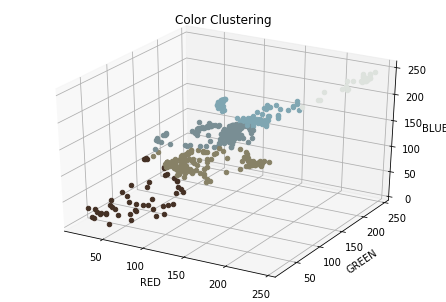

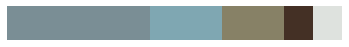

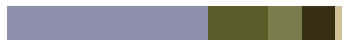

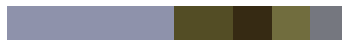

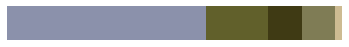

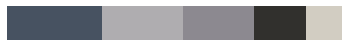

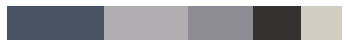

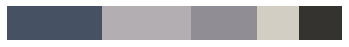

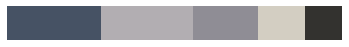

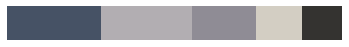

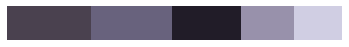

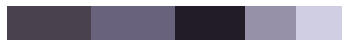

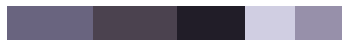

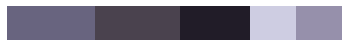

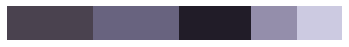

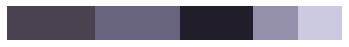

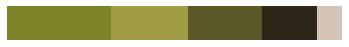

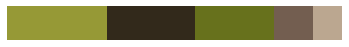

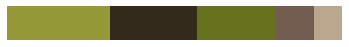

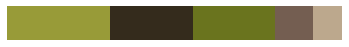

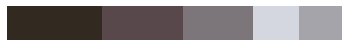

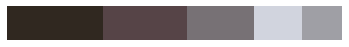

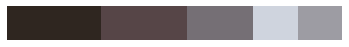

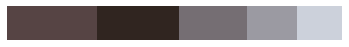

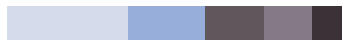

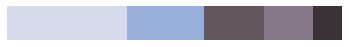

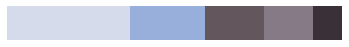

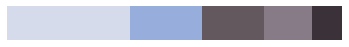

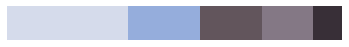

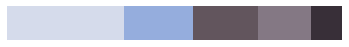

In [0]:
clusters = 5
count = 0
for sample in os.listdir(path_sampling):
    img = path_sampling + sample 
    if(count % int(pow(len(os.listdir(path_sampling)), 1/2)) == 0):
        dc = DominantColors(img, clusters)
        colors = dc.dominantColors()
        if(count == 0):
            dc.plotClusters()
        dc.plotHistogram()
    count += 1

# STEP3 Merge samplings


In [0]:
def pil_grid(images, save_path, max_horiz=np.iinfo(int).max):
    n_images = len(images)
    n_horiz = min(n_images, max_horiz)
    h_sizes, v_sizes = [0] * n_horiz, [0] * (n_images // n_horiz)
    for i, im in enumerate(images):
        h, v = i % n_horiz, i // n_horiz
        h_sizes[h] = max(h_sizes[h], im.size[0])
        v_sizes[v] = max(v_sizes[v], im.size[1])
    h_sizes, v_sizes = np.cumsum([0] + h_sizes), np.cumsum([0] + v_sizes)
    im_grid = Image.new('RGB', (h_sizes[-1], v_sizes[-1]), color='white')
    for i, im in enumerate(images):
        im_grid.paste(im, (h_sizes[i % n_horiz], v_sizes[i // n_horiz]))
    im_grid.save(save_path + 'merge.jpg')

In [0]:
path_merge = 'gdrive/My Drive/Colab Notebooks/VideoVisualization/merge/'
pathlib.Path(path_merge).mkdir(parents=True, exist_ok=True)

images = [ Image.open(path_sampling + sample) for sample in os.listdir(path_sampling) ]
pil_grid(images, path_merge)

In [0]:
clusters = 10
img = path_merge + 'merge.jpg' 
dc = DominantColors(img, clusters)
colors = dc.dominantColors()
#dc.plotClusters()
dc.plotHistogram()

# STEP4 Genre matching
 

In [0]:
import urllib.request
from urllib.error import URLError, HTTPError
from urllib.request import urlopen

path_genre = 'gdrive/My Drive/Colab Notebooks/VideoVisualization/input/genre'

def download_file(url, destination):
    resp = urllib.request.urlopen(url)
    with open(destination, 'wb') as f:
      f.write(resp.read())

df = pd.read_csv(path_genre + '/genres_extract_small.csv',encoding="ISO-8859-1")
genres = []
length = len(df)

for n in range(len(df)):
    index = str(df.loc[n]["imdbId"])
    link = str(df.loc[n]["Poster"])

    if(n % 100 == 0):
        print(str(n) + "/" + str(length) + " is done")

    try:
         data = urlopen(link)
    except HTTPError:
         print("Something bad happened")
    else:
         download_file(link, path_genre + '/posters_extract_small/'  + index + '.jpg')
print("Complete")

0/652 is done
100/652 is done
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
200/652 is done
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
300/652 is done
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
400/652 is done
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
500/652 is done
Something bad happened
Something bad happened
Something bad happened
600/652 is done
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Something bad happened
Complete


In [0]:
import glob
from matplotlib.pyplot import imread

path_posters = 'gdrive/My Drive/Colab Notebooks/VideoVisualization/input/genre/posters_extract_small'
image_glob = glob.glob(path_posters+"/"+"*.jpg")
img_dict = {}
def get_id(filename):
    index_s = filename.rfind("/") + 1
    index_f = filename.rfind(".jpg")
    return filename[index_s:index_f]

_ = [img_dict.update({get_id(fn):imread(fn)}) for fn in image_glob]
#print(img_dict)

In [0]:
len(img_dict)

597

In [0]:
df = pd.read_csv("gdrive/My Drive/Colab Notebooks/VideoVisualization/input/genre/genres_extract_small.csv",encoding="ISO-8859-1")

In [0]:
df.head()

,imdbId,Imdb Link,Title,IMDB Score,Poster,Genre,COUNT
0,5,http://www.imdb.com/title/tt5,Blacksmith Scene (1893),6.2,https://images-na.ssl-images-amazon.com/images...,Short,1
1,192,http://www.imdb.com/title/tt192,"Ella Lola, a la Trilby (1898)",4.8,https://images-na.ssl-images-amazon.com/images...,Short,2
2,399,http://www.imdb.com/title/tt399,Jack and the Beanstalk (1902),6.2,https://images-na.ssl-images-amazon.com/images...,Short,3
3,417,http://www.imdb.com/title/tt417,A Trip to the Moon (1902),8.2,https://images-na.ssl-images-amazon.com/images...,Short,4
4,420,http://www.imdb.com/title/tt420,Alice in Wonderland (1903),6.3,https://images-na.ssl-images-amazon.com/images...,Fantasy,1


In [0]:
genres = []
length = len(df)

for n in range(len(df)):
    g = str(df.loc[n]["Genre"]).split("|")[0]
    genres.append(g)


classes = list(set(genres))
classes.sort()
num_classes = len(classes)

In [0]:
from collections import Counter
class_counts = Counter(genres)

print(len(class_counts))
print(class_counts)

25
Counter({'Short': 30, 'Fantasy': 30, 'Western': 30, 'Romance': 30, 'Mystery': 30, 'War': 30, 'Musical': 30, 'Family': 30, 'Music': 30, 'Thriller': 30, 'Sci-Fi': 30, 'Action': 30, 'Drama': 30, 'Comedy': 30, 'Documentary': 30, 'Crime': 30, 'Animation': 30, 'Adventure': 30, 'Biography': 30, 'Horror': 30, 'History': 24, 'Film-Noir': 16, 'Adult': 7, 'Talk-Show': 3, 'Sport': 2})


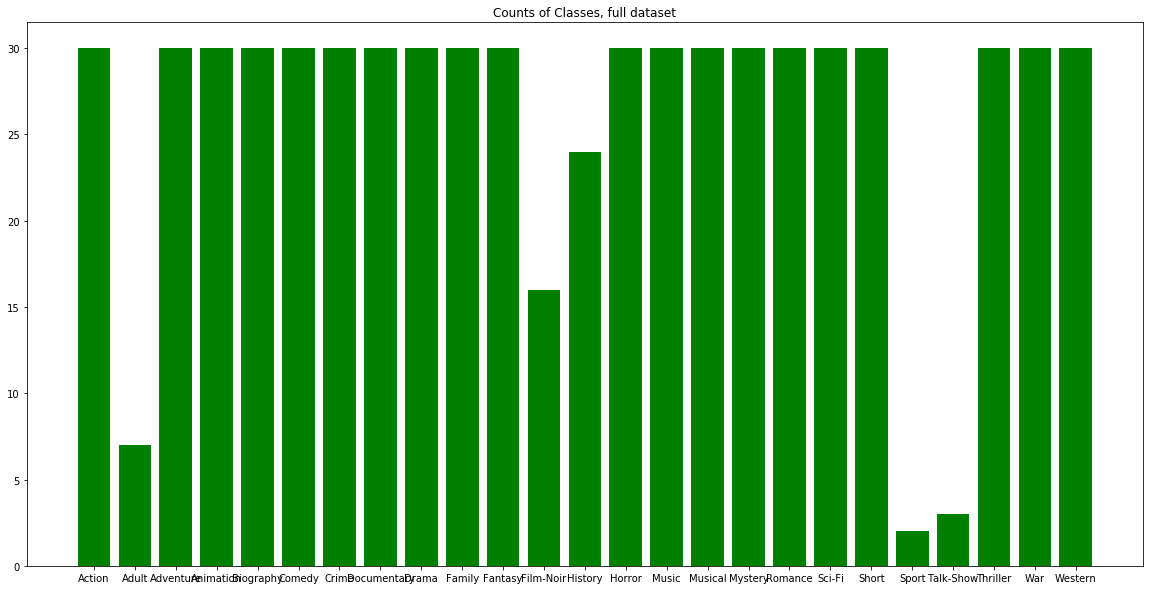

In [0]:
plt.figure(figsize=(20,10))
plt.bar(range(len(class_counts)), [class_counts[key] for key in sorted(class_counts.keys())], align='center', color = 'green')
plt.xticks(range(len(class_counts)), list(sorted(class_counts.keys())))
plt.title('Counts of Classes, full dataset')
plt.show()

In [0]:
import random
from skimage.transform import resize


def get_classes_from_movie(movie_id):
    y = np.zeros(num_classes)
    g = str(df[df['imdbId']==movie_id]['Genre'].values[0])
    y[classes.index(g)] = 1
    return y  

def preprocess(img,size=32):
    img = resize(img,(size,size))
    img = img.astype(float) / 255
    return img
    
def get_dataset(train_size,img_size=32):
    indices = random.sample(range(len(list(img_dict.keys()))),train_size)
    x = []
    y = []
    x_test = []
    y_test = []
    for i in range(len(list(img_dict.keys()))):
        id_key = int(list(img_dict.keys())[i])
        if i in indices:
            x.append(preprocess(img_dict[list(img_dict.keys())[i]],size=img_size))
            y.append(get_classes_from_movie(id_key))
        else:
            x_test.append(preprocess(img_dict[list(img_dict.keys())[i]],size=img_size))
            y_test.append(get_classes_from_movie(id_key))
    return x,y,x_test,y_test

SIZE = 128
x,y,x_test,y_test = get_dataset(50,img_size=SIZE)
x = np.asarray(x)
y = np.asarray(y)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

In [0]:
from keras import backend as K
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()
model.add(Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=(SIZE,SIZE,3)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

model.fit(x, y,
          batch_size=50,
          epochs=5,
          verbose=1,
          validation_data=(x_test, y_test))
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

KeyboardInterrupt: ignored

In [0]:
from sklearn.metrics import classification_report
from sklearn.metrics  import confusion_matrix
import seaborn as sn

In [0]:
y_pred = model.predict(x_test)
pred = []
val = []
for p in y_pred:
    pred.append(classes[np.argmax(p)])
for v in y_test:
    val.append(classes[np.argmax(v)])

print(classification_report(val, pred))
cm = confusion_matrix(val, pred)

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00        21
       Adult       0.00      0.00      0.00         4
   Adventure       0.00      0.00      0.00        27
   Animation       0.00      0.00      0.00        27
   Biography       0.00      0.00      0.00        20
      Comedy       0.00      0.00      0.00        17
       Crime       0.00      0.00      0.00        25
 Documentary       0.00      0.00      0.00        27
       Drama       0.00      0.00      0.00        25
      Family       0.00      0.00      0.00        24
     Fantasy       0.00      0.00      0.00        24
   Film-Noir       0.00      0.00      0.00        15
     History       0.00      0.00      0.00        19
      Horror       0.00      0.00      0.00        16
       Music       0.00      0.00      0.00        24
     Musical       0.04      1.00      0.08        21
     Mystery       0.00      0.00      0.00        25
     Romance       0.00    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


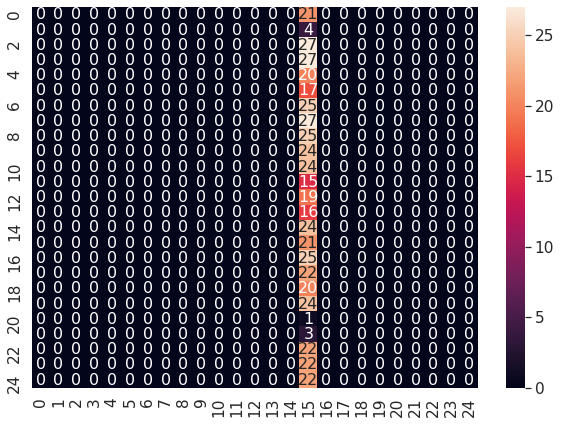

In [0]:
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(cm, annot=True,annot_kws={"size": 16})

In [0]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers
from keras import layers, models
from keras.applications import VGG19
from keras import Input
from keras.models import Model
from keras import optimizers, initializers, regularizers, metrics
from keras.callbacks import ModelCheckpoint

nb_classes = len(classes)

pre_trained_vgg = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
pre_trained_vgg.trainable = True
pre_trained_vgg.summary()

Using TensorFlow backend.






80142336/80134624 [==============================] - 2s 0us/step






Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 128, 128, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 128, 128, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 64, 64, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 64, 64, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 64, 64, 128)       147584    
____________________________________________________

In [0]:
vgg_model = models.Sequential()
vgg_model.add(pre_trained_vgg)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(4096, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
vgg_model.add(layers.Dropout(0.5))
vgg_model.add(layers.Dense(2048, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
vgg_model.add(layers.Dropout(0.5))
vgg_model.add(layers.Dense(1024, kernel_regularizer = regularizers.l1_l2
                                  (l1=0.001,l2=0.001),activation='relu'))
vgg_model.add(layers.Dropout(0.5))
vgg_model.add(layers.Dense(nb_classes, activation='softmax'))

vgg_model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

history = vgg_model.fit(x, y, 
                    batch_size=50, 
                    epochs=5, 
                    validation_data=(x_test, y_test))

score = vgg_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Train on 50 samples, validate on 547 samples
Epoch 1/5
50/50 [==============================] - 158s 3s/step - loss: 558.9355 - acc: 0.9248 - val_loss: 544.8841 - val_acc: 0.9229
Epoch 2/5
50/50 [==============================] - 152s 3s/step - loss: 544.8797 - acc: 0.9232 - val_loss: 534.7354 - val_acc: 0.9229
Epoch 3/5
50/50 [==============================] - 153s 3s/step - loss: 534.6797 - acc: 0.9264 - val_loss: 526.3315 - val_acc: 0.9229
Epoch 4/5
50/50 [==============================] - 153s 3s/step - loss: 526.3528 - acc: 0.9216 - val_loss: 518.9147 - val_acc: 0.9229
Epoch 5/5
50/50 [==============================] - 153s 3s/step - loss: 518.9360 - acc: 0.9216 - val_loss: 512.1819 - val_acc: 0.9229
Test loss: 512.1819368742501
Test accuracy: 0.9229250770382297


In [0]:
y_pred = vgg_model.predict(x_test)
pred = []
val = []
for p in y_pred:
    pred.append(classes[np.argmax(p)])
for v in y_test:
    val.append(classes[np.argmax(v)])

print(classification_report(pred, val))
cm = confusion_matrix(val, pred)

In [0]:
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(cm.astype(int), annot=True,cmap='Greens', fmt='g')

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.4010803e-10]]
PREDICT CLASS : 19
PREDICT GENRE : Short


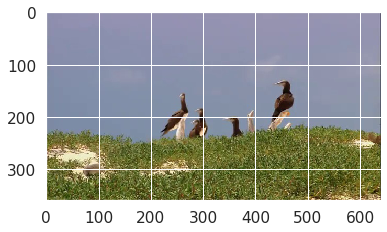

In [0]:
plt.imshow(io.imread(path_sampling + os.listdir(path_sampling)[0]))
img = path_sampling + os.listdir(path_sampling)[0]
pred = vgg_model.predict(np.asarray([preprocess(imread(img),128)]))

print(pred)
print("PREDICT CLASS : " + str(np.argmax(pred)))
print("PREDICT GENRE : " + classes[np.argmax(pred)])

# STEP5 Object Detection


In [0]:
!git clone https://github.com/tensorflow/models.git
!apt-get -qq install libprotobuf-java protobuf-compiler
!protoc ./models/research/object_detection/protos/string_int_label_map.proto --python_out=.
!cp -R models/research/object_detection/ object_detection/
!rm -rf models

Cloning into 'models'...
remote: Enumerating objects: 37, done.
remote: Counting objects: 100% (37/37), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 33394 (delta 12), reused 28 (delta 3), pack-reused 33357
Receiving objects: 100% (33394/33394), 511.98 MiB | 15.37 MiB/s, done.
Resolving deltas: 100% (21322/21322), done.
Checking out files: 100% (3190/3190), done.


In [0]:
from collections import defaultdict
from io import StringIO
import six.moves.urllib as urllib
import sys
import tarfile
import zipfile
import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as vis_util

MODEL_NAME = 'faster_rcnn_inception_resnet_v2_atrous_coco_2017_11_08'

MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
PATH_TO_CKPT = MODEL_NAME + '/frozen_inference_graph.pb'

PATH_TO_LABELS = os.path.join('object_detection/data', 'mscoco_label_map.pbtxt')
NUM_CLASSES = 90

In [0]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
    file_name = os.path.basename(file.name)
    if 'frozen_inference_graph.pb' in file_name:
        tar_file.extract(file, os.getcwd())
    
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

In [0]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [0]:
TEST_IMAGE_PATHS = []
count = 0

for sample in os.listdir(path_sampling):
    img = path_sampling + sample 
    if(count % int(pow(len(os.listdir(path_sampling)), 1/2)) == 0):
        TEST_IMAGE_PATHS.append(img)
    count += 1

IMAGE_SIZE = (12, 8)


with detection_graph.as_default():
    with tf.Session(graph=detection_graph) as sess:
        image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
        detection_boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
        detection_scores = detection_graph.get_tensor_by_name('detection_scores:0')
        detection_classes = detection_graph.get_tensor_by_name('detection_classes:0')
        num_detections = detection_graph.get_tensor_by_name('num_detections:0')
        for image_path in TEST_IMAGE_PATHS:
              image = Image.open(image_path)
              image_np = load_image_into_numpy_array(image)
              image_np_expanded = np.expand_dims(image_np, axis=0)
              (boxes, scores, classes, num) = sess.run(
                    [detection_boxes, detection_scores, detection_classes, num_detections],
                    feed_dict={image_tensor: image_np_expanded})
              vis_util.visualize_boxes_and_labels_on_image_array(
                    image_np,
                    np.squeeze(boxes),
                    np.squeeze(classes).astype(np.int32),
                    np.squeeze(scores),
                    category_index,
                    use_normalized_coordinates=True,
                    line_thickness=8)
              plt.figure(figsize=IMAGE_SIZE)
              plt.imshow(image_np)

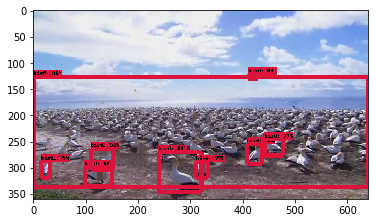

In [0]:
%matplotlib inline

plt.imsave('test.jpg',image_np)
plt.imshow(image_np)
plt.show();